### Install packages

In [1]:
%%bash
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
chmod +x Miniconda3-latest-Linux-x86_64.sh
bash ./Miniconda3-latest-Linux-x86_64.sh  -b -f -p /usr/local
wget https://raw.githubusercontent.com/computational-chemical-biology/ChemWalker/master/environment.yml
conda env create -f environment.yml
#conda install -n chemwalker -c conda-forge multiprocessing

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...





Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories of packages that are compatible with the Python interpreter
    in Miniconda3: /usr/local
Channels:
 - conda-forge
 - rdkit
 - bioconda
 - defaults
Platform: linux-64
Solving environment: ...working... done

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Installing pip dependencies: ...working... Ran pip subprocess with arguments:
['/usr/local/envs/chemwalker/bin/python', '-m', 'pip', 'install', '-U', '-r', '/content/condaenv.3xo24gox.requirements.txt', '--exists-action=b']
Pip subprocess out

--2023-11-29 16:49:34--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120986213 (115M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

     0K .......... .......... .......... .......... ..........  0% 4.32M 27s
    50K .......... .......... .......... .......... ..........  0% 4.53M 26s
   100K .......... .......... .......... .......... ..........  0% 5.28M 25s
   150K .......... .......... .......... .......... ..........  0% 21.3M 20s
   200K .......... .......... .......... .......... ..........  0% 71.7M 16s
   250K .......... .......... .......... .......... ..........  0%  187M 14s
   300K .......... .......... .......... .......... ..........  0%  238M 12s
   350K .......... .......... ........

In [4]:
# Install ChemWalker from github
!/usr/local/envs/chemwalker/bin/pip install git+https://github.com/computational-chemical-biology/ChemWalker.git

  Cloning https://github.com/computational-chemical-biology/ChemWalker.git to /tmp/pip-req-build-f4g5bsr5
  Running command git clone --filter=blob:none --quiet https://github.com/computational-chemical-biology/ChemWalker.git /tmp/pip-req-build-f4g5bsr5
  Resolved https://github.com/computational-chemical-biology/ChemWalker.git to commit cdf9745ccc19a3f8e45413a4b73a937d00dd24fc
  Preparing metadata (setup.py) ... done
  Created wheel for chemwalker: filename=chemwalker-0.0.1-py3-none-any.whl size=31729 sha256=7bc898b26a0eb0cc67822451459ad02f738aba601aaf17b5f18cf492d4aecbfc
  Stored in directory: /tmp/pip-ephem-wheel-cache-jasnjjlt/wheels/22/d9/cb/2284638da48c7fe056f711da6d622ae2e8b284388552707f03
Successfully built chemwalker


In [5]:
# Load libraries from colab default runtime
import sklearn
import multiprocessing
import pandas as pd
import ftplib
import ipaddress
import chardet
pd.__version__

'1.5.3'

In [6]:
import re
cmd = !source activate chemwalker && python --version
ver = re.sub(' |.\d$', '', cmd[0]).lower()
ver

'python3.11'

In [7]:
# Load the remaining libraries from chemwalker env to keep versions consistent
import sys
sys.path = [f'/usr/local/envs/chemwalker/lib/{ver}/site-packages']
sys.path

['/usr/local/envs/chemwalker/lib/python3.11/site-packages']

In [8]:
import networkx
networkx.__version__

'3.2.1'

### Load ChemWalker and auxiliary packages

In [9]:
import os
from chemwalker.gnps import Proteosafe
from chemwalker.utils import run_metfrag, walk_conn_comp, get_db
from chemwalker.draw import *
import numpy as np

### Retrieve data processed by [GNPS](https://gnps.ucsd.edu/) with taskid and obtain:

net: spectral network; gnps: node attributes; spectra: fragmentation spectra; match: spectral library matches.

In [10]:
taskid = 'a0b4377f6e4540268602c30fedf69b0b'

gnps_result = Proteosafe(taskid, 'FBMN')
gnps_result.get_gnps()
net = gnps_result.net
gnps_tab = gnps_result.gnps
spectra = gnps_result.spectra
match_tab = gnps_result.dbmatch

In [ ]:
# Inspect network
net.head()

,CLUSTERID1,CLUSTERID2,ComponentIndex,Cosine,DeltaMZ
0,150,350,1,0.6612,-197.089
1,205,617,1,0.9478,-0.000
2,617,3066,1,0.8151,154.091
3,37,69,1,0.8938,0.000
4,201,238,1,0.9712,34.021


In [ ]:
net.shape

(406, 5)

In [ ]:
# Number of nodes by connected component
net['ComponentIndex'].value_counts().to_dict()

{1: 177,
 3: 55,
 11: 49,
 8: 38,
 6: 32,
 5: 21,
 10: 18,
 15: 3,
 9: 2,
 12: 2,
 17: 2,
 7: 1,
 2: 1,
 4: 1,
 13: 1,
 14: 1,
 16: 1,
 18: 1}

In [ ]:
nset = net['ComponentIndex'].unique().tolist()
nset

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [ ]:
# Library matches
match_tab.head()

,SpectrumID,Compound_Name,Ion_Source,Instrument,Compound_Source,PI,Data_Collector,Adduct,Precursor_MZ,ExactMass,...,FileScanUniqueID,NumberHits,tags,MoleculeExplorerDatasets,MoleculeExplorerFiles,InChIKey,InChIKey-Planar,superclass,class,subclass
0,CCMSLIB00000852203,"NCGC00385365-01_C11H16O3_2(4H)-Benzofuranone, ...",LC-ESI,Maxis II HD Q-TOF Bruker,isolated,Jadhav/Dorrestein,lfnothias,M+H,197.117,196.110,...,spectra_filtered/specs_ms.mgf106,1,NaN,8,131,XEVQXKKKAVVSMW-WRWORJQWSA-N,XEVQXKKKAVVSMW,NaN,NaN,NaN
2,CCMSLIB00000213963,Massbank:FIO00265 Velutin,ESI,LC-ESI-QTOF,Isolated,Putative Massbank Match,Massbank,[M+H]+,315.087,0.000,...,spectra_filtered/specs_ms.mgf1115,1,NaN,0,0,ROCUOVBWAWAQFD-UHFFFAOYSA-N,ROCUOVBWAWAQFD,Phenylpropanoids and polyketides,Flavonoids,O-methylated flavonoids
3,CCMSLIB00000846878,"NCGC00384563-01!5,7-dihydroxy-2-(4-hydroxyphen...",LC-ESI,Maxis II HD Q-TOF Bruker,isolated,Jadhav/Dorrestein,lfnothias,M+H,535.144,534.137,...,spectra_filtered/specs_ms.mgf1129,1,NaN,23,446,LDVNKZYMYPZDAI-UHFFFAOYSA-N,LDVNKZYMYPZDAI,Phenylpropanoids and polyketides,Flavonoids,Flavonoid glycosides
4,CCMSLIB00003236728,Narcissin,ESI,Q-TOF,Isolated,NIST,NIST,M+H,625.176,0.000,...,spectra_filtered/specs_ms.mgf1145,1,NaN,0,0,UIDGLYUNOUKLBM-UHFFFAOYSA-N,UIDGLYUNOUKLBM,Phenylpropanoids and polyketides,Flavonoids,Flavonoid glycosides
6,CCMSLIB00000578403,chafuroside A,LC-ESI,qTof,Isolated,TJ Ling,TJ Ling,M+H,415.102,414.095,...,spectra_filtered/specs_ms.mgf131,1,NaN,0,0,DZQBNDGXEFWXEK-STSJCENXSA-N,DZQBNDGXEFWXEK,Phenylpropanoids and polyketides,Flavonoids,Flavones


In [ ]:
match_tab.columns

Index(['SpectrumID', 'Compound_Name', 'Ion_Source', 'Instrument',
       'Compound_Source', 'PI', 'Data_Collector', 'Adduct', 'Precursor_MZ',
       'ExactMass', 'Charge', 'CAS_Number', 'Pubmed_ID', 'Smiles', 'INCHI',
       'INCHI_AUX', 'Library_Class', 'IonMode', 'UpdateWorkflowName',
       'LibraryQualityString', '#Scan#', 'SpectrumFile', 'LibraryName',
       'MQScore', 'Organism', 'TIC_Query', 'RT_Query', 'MZErrorPPM',
       'SharedPeaks', 'MassDiff', 'LibMZ', 'SpecMZ', 'SpecCharge',
       'FileScanUniqueID', 'NumberHits', 'tags', 'MoleculeExplorerDatasets',
       'MoleculeExplorerFiles', 'InChIKey', 'InChIKey-Planar', 'superclass',
       'class', 'subclass'],
      dtype='object')

In [ ]:
gnps_tab.head()

,ATTRIBUTE_AB,ATTRIBUTE_AFE,ATTRIBUTE_Asat,ATTRIBUTE_C,ATTRIBUTE_C/N,ATTRIBUTE_CMSF,ATTRIBUTE_CS,ATTRIBUTE_Family,ATTRIBUTE_Forest_Region,ATTRIBUTE_Genus,...,SpectrumID,SumPeakIntensity,UniqueFileSourcesCount,cluster index,componentindex,number of spectra,parent mass,precursor charge,precursor mass,sum(precursor intensity)
0,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,1.348335e+07,12,5,-1,12,353.2654,1,353.2654,1.348335e+07
1,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,1.274737e+07,12,7,-1,12,381.2963,1,381.2963,1.274737e+07
2,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,1.215391e+07,12,8,11,12,581.1482,1,581.1482,1.215391e+07
3,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,1.239457e+07,11,10,8,11,609.2684,1,609.2684,1.239457e+07
4,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,6.553864e+06,11,13,-1,11,305.1565,1,305.1565,6.553864e+06


In [ ]:
spectra[0]

{'params': {'feature_id': '5',
  'pepmass': (353.2654, None),
  'scans': '5',
  'rtinseconds': 2107.174 second,
  'charge': [1],
  'mslevel': '2'},
 'm/z array': array([353.2602, 354.2637, 355.2699, 400.2479]),
 'intensity array': array([2000.,  590.,   74.,   62.]),
 'charge array': masked_array(data=[--, --, --, --],
              mask=[ True,  True,  True,  True],
        fill_value=0,
             dtype=int64)}

In [ ]:
gnps_result.check_comp(11)

Component of 12 nodes, with 6 InChI or Smiles present.


### Retrieve example structure database

In [11]:
db = get_db()
db.head()

,MonoisotopicMass,InChI,SMILES,Identifier,InChIKey2,InChIKey1,MolecularFormula,kingdom_name,superclass_name,class_name,subclass_name
0,194.05791,InChI=1/C10H10O4/c1-14-9-6-7(2-4-8(9)11)3-5-10...,COC1=C(C=CC(=C1)C=CC(=O)O)O,CCMSLIB00000220714,UHFFFAOYSA,KSEBMYQBYZTDHS,C10H10O4,Organic compounds,Phenylpropanoids and polyketides,Cinnamic acids and derivatives,Hydroxycinnamic acids and derivatives
1,176.09496,InChI=1/C10H12N2O/c11-4-3-7-6-12-10-2-1-8(13)5...,C1=CC2=C(C=C1O)C(=CN2)CCN,CCMSLIB00000220735,UHFFFAOYSA,QZAYGJVTTNCVMB,C10H12N2O,Organic compounds,Organoheterocyclic compounds,Indoles and derivatives,Tryptamines and derivatives
2,176.04734,InChI=1/C10H8O3/c1-6-4-10(12)13-9-5-7(11)2-3-8...,CC1=CC(=O)OC2=C1C=CC(=C2)O,CCMSLIB00000221773,UHFFFAOYSA,HSHNITRMYYLLCV,C10H8O3,NaN,NaN,NaN,NaN
3,345.07864,"InChI=1/C12H17N4O4PS/c1-8-11(3-4-20-21(17,18)1...",CC1=C(SC=[N+]1CC2=CN=C(N=C2N)C)CCOP(=O)(O)O,CCMSLIB00000221098,UHFFFAOYSA,HZSAJDVWZRBGIF,C12H18N4O4PS,Organic compounds,Organoheterocyclic compounds,Diazines,Pyrimidines and pyrimidine derivatives
4,342.11621,InChI=1/C12H22O11/c13-1-4-6(15)8(17)9(18)11(22...,C(C1C(C(C(C(O1)OCC2C(C(C(O2)(CO)O)O)O)O)O)O)O,CCMSLIB00000222747,UHFFFAOYSA,PVXPPJIGRGXGCY,C12H22O11,NaN,NaN,NaN,NaN


In [ ]:
db.shape

(367204, 11)

### Retrieve and test MetFrag2.3.-CL

In [ ]:
!wget http://ccbl.fcfrp.usp.br/ccbl/MetFrag2.3-CL.jar

--2023-11-23 18:32:30--  http://ccbl.fcfrp.usp.br/ccbl/MetFrag2.3-CL.jar
Resolving ccbl.fcfrp.usp.br (ccbl.fcfrp.usp.br)... 200.144.245.3
Connecting to ccbl.fcfrp.usp.br (ccbl.fcfrp.usp.br)|200.144.245.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34448208 (33M) [application/java-archive]
Saving to: ‘MetFrag2.3-CL.jar’

MetFrag2.3-CL.jar   100%[===================>]  32.85M  11.2MB/s    in 2.9s    

2023-11-23 18:32:36 (11.2 MB/s) - ‘MetFrag2.3-CL.jar’ saved [34448208/34448208]



In [ ]:
# https://ipb-halle.github.io/MetFrag/projects/metfragcl/
metpath = os.path.abspath('MetFrag2.3-CL.jar')
metpath

'/content/MetFrag2.3-CL.jar'

In [ ]:
len(spectra)

486

In [ ]:
gnps_tab.head()

,ATTRIBUTE_AB,ATTRIBUTE_AFE,ATTRIBUTE_Asat,ATTRIBUTE_C,ATTRIBUTE_C/N,ATTRIBUTE_CMSF,ATTRIBUTE_CS,ATTRIBUTE_Family,ATTRIBUTE_Forest_Region,ATTRIBUTE_Genus,...,SpectrumID,SumPeakIntensity,UniqueFileSourcesCount,cluster index,componentindex,number of spectra,parent mass,precursor charge,precursor mass,sum(precursor intensity)
0,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,1.348335e+07,12,5,-1,12,353.2654,1,353.2654,1.348335e+07
1,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,1.274737e+07,12,7,-1,12,381.2963,1,381.2963,1.274737e+07
2,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,1.215391e+07,12,8,11,12,581.1482,1,581.1482,1.215391e+07
3,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,1.239457e+07,11,10,8,11,609.2684,1,609.2684,1.239457e+07
4,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,6.553864e+06,11,13,-1,11,305.1565,1,305.1565,6.553864e+06


In [ ]:
run_metfrag(spectra[0], db, cluster_index=5, **{'metpath': metpath})

,Score,InChI,FragmenterScore_Values,MaximumTreeDepth,SmilesOfExplPeaks,MonoisotopicMass,Identifier,MolecularFormula,FormulasOfExplPeaks,InChIKey2,InChIKey1,FragmenterScore,ExplPeaks,NoExplPeaks,NumberPeaksUsed,cluster index
0,0.0,InChI=1S/C21H36O4/c1-2-3-4-5-6-7-8-9-10-11-12-...,NaN,2,NaN,352.26136,HMDB11570,C21H36O4,NaN,IWFQAGGASA,GGJRAQULURVTAJ,0.0,NaN,0,0,5
1,0.0,InChI=1S/C21H36O4/c1-2-3-4-5-6-7-8-9-10-11-12-...,NaN,2,NaN,352.26136,HMDB11569,C21H36O4,NaN,FFXVNFNPSA,XQBHBEXBUZDCRY,0.0,NaN,0,0,5
2,0.0,InChI=1S/C21H36O4/c1-2-3-4-5-6-7-8-9-10-11-12-...,NaN,2,NaN,352.26136,HMDB11540,C21H36O4,NaN,PDBXOOCHSA,ZCCLDKGWJIREQF,0.0,NaN,0,0,5
3,0.0,InChI=1S/C21H36O4/c1-2-3-4-5-6-7-8-9-10-11-12-...,NaN,2,NaN,352.26136,HMDB11539,C21H36O4,NaN,QNEBEIHSSA,BXAXVVVVPFELOK,0.0,NaN,0,0,5
4,0.0,InChI=1S/C17H30N6O2/c1-21(2)9-14-10-23(20-19-1...,NaN,2,NaN,352.25867,SN00003763,C17H32N6O2+2,NaN,IMJJTQAJSA,ARTRYHKUYFBLMW,0.0,NaN,0,0,5
5,0.0,InChI=1S/C21H36O4/c1-12(2)14-8-7-13(3)17-15-11...,NaN,2,NaN,352.26136,SN00336671,C21H36O4,NaN,FQOJGSFKSA,OEUGMHUKLQIMAL,0.0,NaN,0,0,5
6,0.0,InChI=1S/C21H36O4/c1-12(22)15-7-9-21(25)16-5-4...,NaN,2,NaN,352.26136,SN00314125,C21H36O4,NaN,ISKWUEMLSA,FTIPFRDCMUGVRU,0.0,NaN,0,0,5
7,0.0,InChI=1S/C21H36O4/c1-12(22)21(25)9-7-16-15-5-4...,NaN,2,NaN,352.26136,SN00365925,C21H36O4,NaN,HHDQNTOOSA,ICLJUDISOCRJDM,0.0,NaN,0,0,5
8,0.0,InChI=1S/C21H36O4/c1-13(11-18(23)25-6)7-9-20(4...,NaN,2,NaN,352.26136,SN00257279,C21H36O4,NaN,FCFMDSSISA,QFSPHXMKLQWTLA,0.0,NaN,0,0,5
9,0.0,InChI=1S/C21H36O4/c1-14(10-13-25-6)8-9-15-20(4...,NaN,2,NaN,352.26136,SN00267497,C21H36O4,NaN,GPLUPSNSSA,KOMLQPBMYPUDGX,0.0,NaN,0,0,5


### Perform propagation inside a given connected component

In [ ]:
%%time

tlid = walk_conn_comp(net=net, spectra=spectra, tabgnps=gnps_tab,
                      dbmatch=match_tab.copy(), db=db, comp_index=11,
                      metpath=metpath)

Component with 12 nodes
Calculating in silico fragmentation with MetFrag...
in silico fragmentation done in: 204.75141215324402 seconds
Calculating pairwise candidate similarities...
similarities done in: 158.94839072227478 seconds
Seed - InChIKey1:FIAAVMJLAGNUKW, cluster index:31, Identifier:CCMSLIB00000845378
Seed - InChIKey1:FIAAVMJLAGNUKW, cluster index:133, Identifier:CCMSLIB00000845378
Seed - InChIKey1:FIAAVMJLAGNUKW, cluster index:199, Identifier:CCMSLIB00000845378
Seed - InChIKey1:MVOUGOXRXQDXDC, cluster index:675, Identifier:CCMSLIB00000848557
Seed - InChIKey1:LDVNKZYMYPZDAI, cluster index:1129, Identifier:CCMSLIB00000846878
Seed - InChIKey1:OVMFOVNOXASTPA, cluster index:1713, Identifier:CCMSLIB00000848866
Walking on the graph...
walking done in: 0.2765817642211914 seconds
CPU times: user 21.1 s, sys: 854 ms, total: 21.9 s
Wall time: 6min 4s


In [ ]:
net[net['ComponentIndex']==11]

,CLUSTERID1,CLUSTERID2,ComponentIndex,Cosine,DeltaMZ
346,8,347,11,0.7990,-0.001
347,347,1129,11,0.6834,46.006
348,199,347,11,0.6218,14.015
349,31,1713,11,0.8926,30.011
350,8,1713,11,0.9165,15.995
351,2851,3005,11,0.7744,-30.008
352,2793,2851,11,0.7323,79.952
353,31,133,11,0.7577,0.000
354,8,2851,11,0.8697,16.025
355,8,3196,11,0.7586,4.027


### Inspect results

/usr/local/envs/chemwalker/lib/python3.11/site-packages/chemwalker/draw.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attr.sort_values(score, ascending=False, inplace=True)


87     InChI=1/C26H28O15/c27-5-13-18(33)21(36)23(38)2...
88     InChI=1/C26H28O15/c27-5-13-18(33)21(36)23(38)2...
92     InChI=1S/C26H28O15/c27-5-13-17(32)20(35)21(36)...
95     InChI=1S/C26H28O15/c27-5-12-17(32)21(36)23(38)...
71     InChI=1S/C26H28O15/c27-6-16-21(41-25-24(36)26(...
                             ...                        
100    InChI=1S/C26H28O15/c1-7-12(4-9-15(16(7)29)17(3...
98     InChI=1S/C28H24N2O12/c1-3-39-27(33)23(41-25(31...
97     InChI=1S/C33H26Cl2N4O2/c1-3-20-26(36-30-22-9-5...
107    InChI=1S/C30H28O10S/c1-4-5-6-7-14-10-15-8-9-17...
108    InChI=1S/C30H32O8P2/c31-39(32,25-11-3-1-4-12-2...
Name: InChI, Length: 106, dtype: object


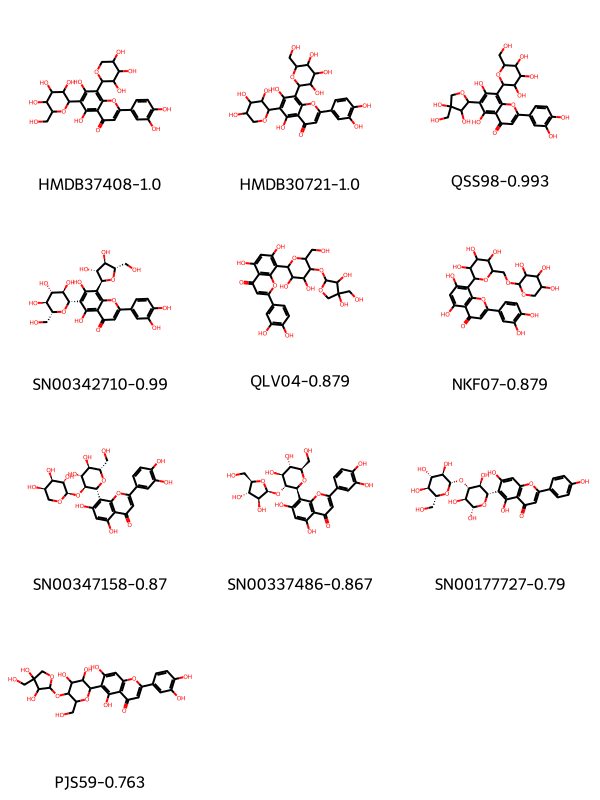

In [ ]:
plotPannel(tlid, clusterid=8)

3      InChI=1S/C26H28O15/c27-8-26(36)9-37-25(22(26)3...
4      InChI=1S/C26H28O15/c1-9-17(30)20(33)22(35)26(3...
5      InChI=1S/C26H28O15/c27-7-14-17(30)19(32)23(36)...
6      InChI=1S/C29H26ClFN4O4S/c1-40(36,37)12-11-32-1...
7      InChI=1S/C29H28ClN3O8/c1-14-13-40-26-16(3)27-2...
                             ...                        
104    InChI=1S/C26H28O15/c27-7-18-21(34)22(35)24(41-...
105    InChI=1S/C26H28O15/c27-7-18-21(33)22(34)24(36)...
106    InChI=1S/C26H28O15/c1-8-17(31)20(34)22(36)25(3...
107    InChI=1S/C30H28O10S/c1-4-5-6-7-14-10-15-8-9-17...
108    InChI=1S/C30H32O8P2/c31-39(32,25-11-3-1-4-12-2...
Name: InChI, Length: 106, dtype: object


/usr/local/envs/chemwalker/lib/python3.11/site-packages/chemwalker/draw.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attr.sort_values(score, ascending=False, inplace=True)


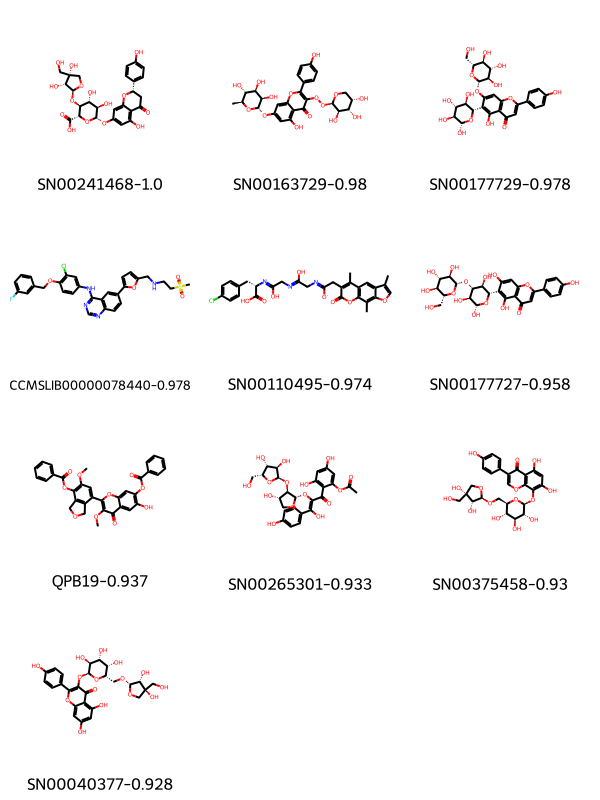

In [ ]:
plotPannel(tlid, clusterid=8, score='Score')

In [ ]:
if not os.path.exists('figs'):
    os.mkdir('figs')

plotGraph(match_tab, gnps_tab, tlid, net, method='MF',
         dr='figs', comp=11, option=1, pos_scale=300)

plotGraph(match_tab, gnps_tab, tlid, net, method='RW',
         dr='figs', comp=11, option=1, pos_scale=300)

In [ ]:
tlid['cluster index'].value_counts()

8       106
347     105
3196      5
2851      3
3005      2
2793      1
31        1
133       1
199       1
675       1
1129      1
1713      1
Name: cluster index, dtype: int64

In [ ]:
!ls

comp_11_MF.html  figs				    parameter_file_3007.txt  validation_db_3007.psv
comp_11_RW.html  MetFrag2.3-CL.jar		    sample_data
environment.yml  Miniconda3-latest-Linux-x86_64.sh  spec_3007_data.txt


### Create a compressed file with interactive html for download

Click the folder icon and download the file.

In [ ]:
!zip -r res_chw.zip figs/ comp_11_MF.html comp_11_RW.html

  adding: figs/ (stored 0%)
  adding: figs/RW_3196.png (deflated 3%)
  adding: figs/MF_2851.png (deflated 4%)
  adding: figs/LM_1713.png (deflated 6%)
  adding: figs/MF_347.png (deflated 4%)
  adding: figs/MF_2793.png (deflated 4%)
  adding: figs/LM_199.png (deflated 5%)
  adding: figs/LM_133.png (deflated 5%)
  adding: figs/RW_2793.png (deflated 4%)
  adding: figs/RW_3005.png (deflated 5%)
  adding: figs/MF_3005.png (deflated 5%)
  adding: figs/RW_347.png (deflated 5%)
  adding: figs/LM_1129.png (deflated 7%)
  adding: figs/RW_2851.png (deflated 4%)
  adding: figs/RW_8.png (deflated 6%)
  adding: figs/LM_31.png (deflated 5%)
  adding: figs/MF_3196.png (deflated 4%)
  adding: figs/MF_8.png (deflated 4%)
  adding: figs/LM_675.png (deflated 6%)
  adding: comp_11_MF.html (deflated 81%)
  adding: comp_11_RW.html (deflated 81%)
